# Laboratory Session 02

Student: Alice Pagano, Alessandra Sabatti

In [1]:
# Import main packages 
import pandas as pd
import numpy as np
import scipy as sp
#import seaborn as sns
import matplotlib.pyplot as plt
import bokeh.palettes as palette # For palette of colors
import time
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors

import os
from lmfit.models import PseudoVoigtModel, LinearModel
from scipy.integrate import trapz, simps

#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
### for Palatino and other serif fonts use:
##rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True) 

### Load data

In [2]:
# Import experimental Bulk Dielectric Function for Au 
path      = "data2/data.txt"
cols      = pd.read_csv(path, sep="\s+", nrows=1, header=None).iloc[0].values[0:]
data = pd.read_csv(path,sep="\s+",skiprows=1,header=None,names=cols)

data

,x,y
0,30.025,1672.0
1,30.075,1631.0
2,30.125,1620.0
3,30.175,1658.0
4,30.225,1551.0
...,...,...
1195,89.775,410.0
1196,89.825,401.0
1197,89.875,436.0
1198,89.925,406.0


### Plot data

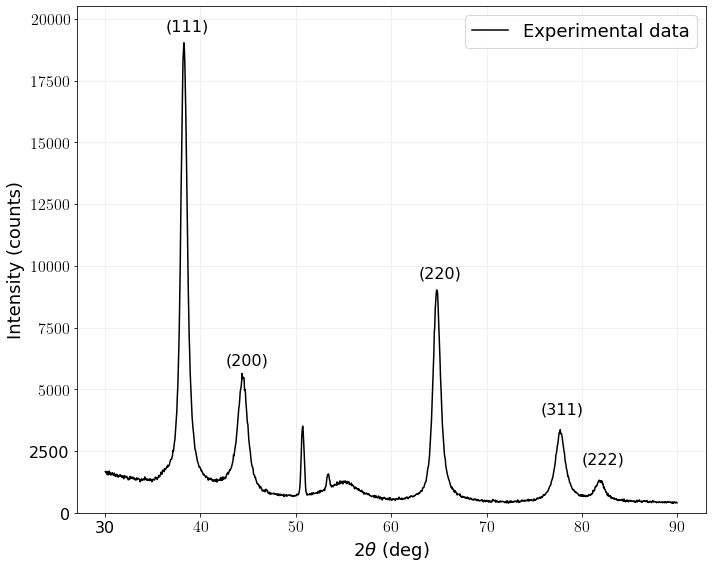

In [3]:
# Plot of experimental results ##DA INSERIRE E INSERIRE TARGHE INDICI
fig, (ax1) = plt.subplots(1, 1, figsize=(10,8))

ax1.plot(data['x'],data['y'],'-',color='#000003',label='Experimental data')

#ax1.set_title(r'Plot of absorbtion as a function of the wavelength',fontsize=20)
ax1.set_xlabel(r'$ 2 \theta$ (deg)',fontsize=18)
ax1.set_ylabel(r'Intensity (counts)',fontsize=18)
ax1.grid(color='0.93')
ax1.legend(title='',fontsize=18,  title_fontsize=18,loc='upper right')
ax1.set_ylim(0,20500)

if not os.path.isdir('./data2/images'):
        os.mkdir('./data2/images')
        
plt.text(36.4, 19500, r'(111)', fontsize=16)
plt.text(42.6, 6000, r'(200)', fontsize=16)
plt.text(62.90, 9500, r'(220)', fontsize=16)
plt.text(75.7, 4000, r'(311)', fontsize=16)
plt.text(80, 2000, r'(222)', fontsize=16)

ax1.tick_params(axis="x", labelsize=16)
ax1.tick_params(axis="y", labelsize=16)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('data2/images/scattering_intensity.pdf', format='pdf')


### Fit of 5 peaks

In [4]:
beta_instrumental = 0.27/180 * np.pi
K_fwhm = 0.89
K_breadth = 1.07
lambda_Cu = 0.15406

#### Fit 1

[[Model]]
    (Model(pvoigt, prefix='peak_') + Model(linear, prefix='linear_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 90
    # variables        = 6
    chi-square         = 2237565.10
    reduced chi-square = 26637.6797
    Akaike info crit   = 922.898024
    Bayesian info crit = 937.896882
[[Variables]]
    peak_amplitude:    349.672800 +/- 4.23620362 (1.21%) (init = 430.0055)
    peak_center:       0.66815950 +/- 2.5038e-05 (0.00%) (init = 0.6684611)
    peak_sigma:        0.00698648 +/- 4.2917e-05 (0.61%) (init = 0.006544985)
    peak_fraction:     0.74204079 +/- 0.02214493 (2.98%) (init = 0.5)
    peak_fwhm:         0.01397295 +/- 8.5834e-05 (0.61%) == '2.0000000*peak_sigma'
    peak_height:       17886.2104 +/- 89.6842746 (0.50%) == '(((1-peak_fraction)*peak_amplitude)/max(2.220446049250313e-16, (peak_sigma*sqrt(pi/log(2))))+(peak_fraction*peak_amplitude)/max(2.220446049250313e-16, (pi*peak_sigma)))'
    linear_slo

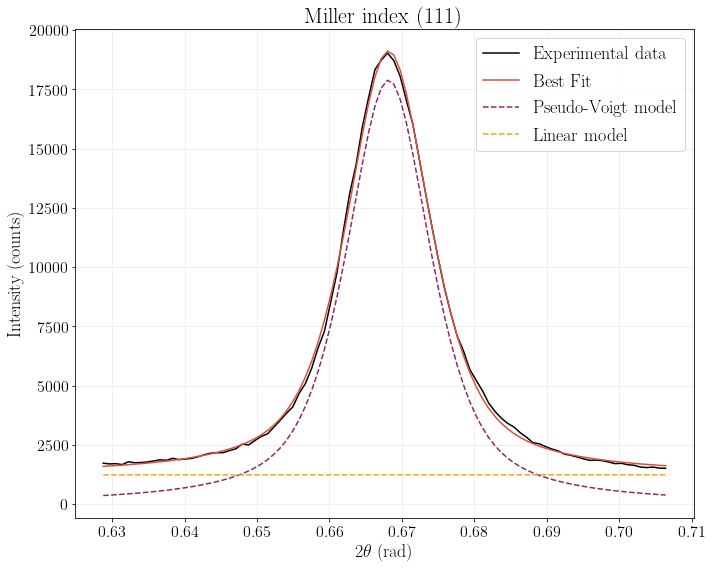

In [5]:
data_peak_1 = data[data['x']>=36]
data_peak_1 = data_peak_1[data_peak_1['x']<=40.5]

x = np.array( data_peak_1['x'] )/180 * np.pi
y = np.array( data_peak_1['y'] )

peak = PseudoVoigtModel(prefix='peak_')
pars = peak.guess(y, x=x)

background = LinearModel(prefix='linear_')
pars.update(background.make_params())

# MODEL
model = peak + background

out = model.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.5))

center_1 = out.params['peak_center'].value
sigma_1  = out.params['peak_sigma'].value
fwhm_1   = out.params['peak_fwhm'].value
height_1 = out.params['peak_height'].value

comps = out.eval_components(x=x)

y_peak = np.array(comps['peak_'])

data_d = {'x': x, 'y': y_peak}
data_int = pd.DataFrame(data=data_d)
data_int = data_int[data_int['x']>=(center_1-3*fwhm_1/2)]
data_int = data_int[data_int['x']<=(center_1+3*fwhm_1/2)]

integral_1 = trapz(data_int['y'], data_int['x'])
beta_breadth_1  = np.sqrt( np.power(integral_1/height_1,2) - np.power(beta_instrumental,2) )
beta_fwhm_1     = np.sqrt( np.power(fwhm_1,2) - np.power(beta_instrumental,2) )

#beta_breadth_1 = integral_1/height_1 - beta_instrumental
#beta_fwhm_1 =  fwhm_1 - beta_instrumental

D_v_fwhm_1 = K_fwhm * lambda_Cu/ (beta_fwhm_1* np.cos(center_1/2))
D_v_breadth_1 = K_breadth * lambda_Cu/ (beta_breadth_1* np.cos(center_1/2))

print('\n')
print('Beta: FWHM = {:18.16f}'.format(beta_fwhm_1))
print('Beta: Integral breadth = {:18.16f}'.format(beta_breadth_1))
print('D FWHM = {:18.16f}'.format(D_v_fwhm_1))
print('D breadth = {:18.16f}'.format(D_v_breadth_1))


fig, axes = plt.subplots(1, 1, figsize=(10, 8))

axes.plot(x, y, 'b',color='#000003',label='Experimental data')
axes.plot(x, out.best_fit, 'r-', color='#DC5039',label='Best Fit')
axes.plot(x, comps['peak_'], 'g--', color='#932567', label='Pseudo-Voigt model')
axes.plot(x, comps['linear_'], 'm--', color='#FBA40A', label='Linear model')
axes.legend(loc='best',fontsize=18)
#axes[1].axvline(x=center_1,color='green')
axes.set_xlabel(r'$ 2 \theta$ (rad)',fontsize=18)
axes.set_ylabel(r'Intensity (counts)',fontsize=18)
axes.tick_params(axis="x", labelsize=16)
axes.tick_params(axis="y", labelsize=16)
axes.grid(color='0.93')
axes.set_title(r'Miller index (111)',fontsize=22)

if not os.path.isdir('./data2/images'):
        os.mkdir('./data2/images')
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('data2/images/1_peak.pdf', format='pdf')

In [6]:
#y_fit = out.best_fit
##x[np.argmax(y_fit)]
#
#def lin_interp(x, y, i, half):
#    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))
#
#def half_max_x(x, y):
#    half = max(y)/2.0
#    signs = np.sign(np.add(y, -half))
#    zero_crossings = (signs[0:-2] != signs[1:-1])
#    zero_crossings_i = np.where(zero_crossings)[0]
#    return [lin_interp(x, y, zero_crossings_i[0], half),
#            lin_interp(x, y, zero_crossings_i[1], half)]
#
#hmx = half_max_x(x,y_fit)
#
## print the answer
#fwhm = hmx[1] - hmx[0]
#
#fwhm = np.sqrt( np.power(fwhm,2) - np.power(beta_instrumental,2) )
#D_v_fwhm = K_fwhm * lambda_Cu/ (fwhm* np.cos(center_1))
#
#
#print("FWHM:{:.3f}".format(fwhm))
#print('D FWHM = {:18.16f}'.format(D_v_fwhm_1))
#print('D FWHM new = {:18.16f}'.format(D_v_fwhm))
#
## a convincing plot
#half = max(y)/2.0
#plt.plot(x,y_fit,'red')
#plt.plot(hmx, [half, half])
#plt.show()

#### Fit 2

[[Model]]
    (Model(pvoigt, prefix='peak_') + Model(linear, prefix='linear_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 100
    # variables        = 6
    chi-square         = 374591.269
    reduced chi-square = 3985.01350
    Akaike info crit   = 834.842058
    Bayesian info crit = 850.473079
[[Variables]]
    peak_amplitude:    140.232282 +/- 3.12905280 (2.23%) (init = 187.9065)
    peak_center:       0.77556453 +/- 4.8690e-05 (0.01%) (init = 0.7753625)
    peak_sigma:        0.01063117 +/- 8.6948e-05 (0.82%) (init = 0.01047198)
    peak_fraction:     0.79780981 +/- 0.03334646 (4.18%) (init = 0.5)
    peak_fwhm:         0.02126235 +/- 1.7390e-04 (0.82%) == '2.0000000*peak_sigma'
    peak_height:       4602.53082 +/- 36.9947612 (0.80%) == '(((1-peak_fraction)*peak_amplitude)/max(2.220446049250313e-16, (peak_sigma*sqrt(pi/log(2))))+(peak_fraction*peak_amplitude)/max(2.220446049250313e-16, (pi*peak_sigma)))'
    linear_slo

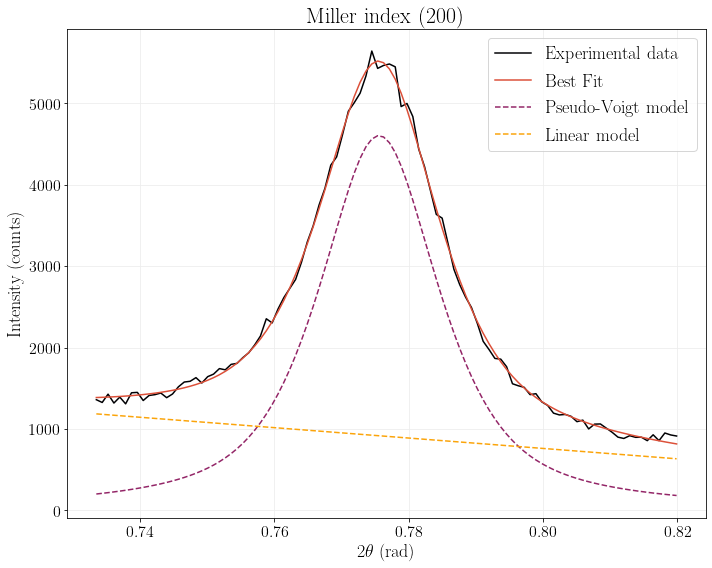

In [7]:
data_peak_2 = data[data['x']>=42]
data_peak_2 = data_peak_2[data_peak_2['x']<=47]

x = np.array( data_peak_2['x'] )/180 * np.pi
y = np.array( data_peak_2['y'] )

peak = PseudoVoigtModel(prefix='peak_')
pars = peak.guess(y, x=x)

background = LinearModel(prefix='linear_')
pars.update(background.make_params())

# MODEL
model = peak + background

out = model.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.5))


center_2 = out.params['peak_center'].value
sigma_2  = out.params['peak_sigma'].value
fwhm_2   = out.params['peak_fwhm'].value
height_2 = out.params['peak_height'].value

comps = out.eval_components(x=x)

y_peak = np.array(comps['peak_'])

data_d = {'x': x, 'y': y_peak}
data_int = pd.DataFrame(data=data_d)
data_int = data_int[data_int['x']>=(center_2-3*fwhm_2/2)]
data_int = data_int[data_int['x']<=(center_2+3*fwhm_2/2)]

integral_2 = trapz(data_int['y'], data_int['x'])

beta_breadth_2 = np.sqrt( np.power(integral_2/height_2,2) - np.power(beta_instrumental,2) )
beta_fwhm_2 = np.sqrt( np.power(fwhm_2,2) - np.power(beta_instrumental,2) )

#beta_breadth_2 = integral_2/height_2 - beta_instrumental
#beta_fwhm_2 =  fwhm_2 - beta_instrumental

D_v_fwhm_2 = K_fwhm * lambda_Cu/ (beta_fwhm_2* np.cos(center_2/2))
D_v_breadth_2 = K_breadth * lambda_Cu/ (beta_breadth_2* np.cos(center_2/2))

print('\n')
print('Beta: FWHM = {:18.16f}'.format(beta_fwhm_2))
print('Beta: Integral breadth = {:18.16f}'.format(beta_breadth_2))
print('D FWHM = {:18.16f}'.format(D_v_fwhm_2))
print('D breadth = {:18.16f}'.format(D_v_breadth_2))


fig, axes = plt.subplots(1, 1, figsize=(10, 8))

axes.plot(x, y, 'b',color='#000003',label='Experimental data')
axes.plot(x, out.best_fit, 'r-', color='#DC5039',label='Best Fit')
axes.plot(x, comps['peak_'], 'g--', color='#932567', label='Pseudo-Voigt model')
axes.plot(x, comps['linear_'], 'm--', color='#FBA40A', label='Linear model')
axes.legend(loc='best',fontsize=18)
#axes[1].axvline(x=center_1,color='green')
axes.set_xlabel(r'$ 2 \theta$ (rad)',fontsize=18)
axes.set_ylabel(r'Intensity (counts)',fontsize=18)
axes.tick_params(axis="x", labelsize=16)
axes.tick_params(axis="y", labelsize=16)
axes.grid(color='0.93')
axes.set_title(r'Miller index (200)',fontsize=22)

if not os.path.isdir('./data2/images'):
        os.mkdir('./data2/images')
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('data2/images/2_peak.pdf', format='pdf')

#### Fit 3

[[Model]]
    (Model(pvoigt, prefix='peak_') + Model(linear, prefix='linear_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 160
    # variables        = 6
    chi-square         = 513550.685
    reduced chi-square = 3334.74471
    Akaike info crit   = 1303.82883
    Bayesian info crit = 1322.27987
[[Variables]]
    peak_amplitude:    198.380043 +/- 1.11603484 (0.56%) (init = 237.1052)
    peak_center:       1.13080789 +/- 1.9541e-05 (0.00%) (init = 1.130973)
    peak_sigma:        0.00799725 +/- 3.5182e-05 (0.44%) (init = 0.007417649)
    peak_fraction:     0.81052309 +/- 0.01164877 (1.44%) (init = 0.5)
    peak_fwhm:         0.01599451 +/- 7.0364e-05 (0.44%) == '2.0000000*peak_sigma'
    peak_height:       8607.64885 +/- 25.5700381 (0.30%) == '(((1-peak_fraction)*peak_amplitude)/max(2.220446049250313e-16, (peak_sigma*sqrt(pi/log(2))))+(peak_fraction*peak_amplitude)/max(2.220446049250313e-16, (pi*peak_sigma)))'
    linear_slo

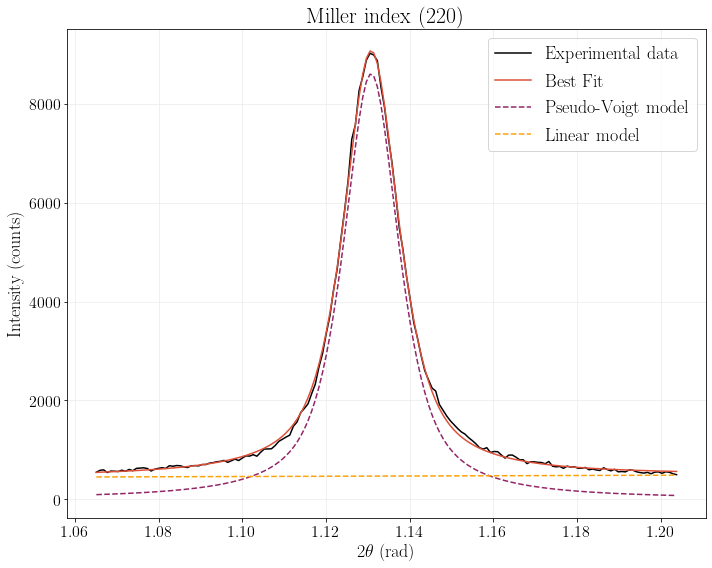

In [8]:
data_peak_3 = data[data['x']>=61]
data_peak_3 = data_peak_3[data_peak_3['x']<=69]

x = np.array( data_peak_3['x'] )/180 * np.pi
y = np.array( data_peak_3['y'] )

peak = PseudoVoigtModel(prefix='peak_')
pars = peak.guess(y, x=x)

background = LinearModel(prefix='linear_')
pars.update(background.make_params())

# MODEL
model = peak + background

out = model.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.5))


center_3 = out.params['peak_center'].value
sigma_3  = out.params['peak_sigma'].value
fwhm_3   = out.params['peak_fwhm'].value
height_3 = out.params['peak_height'].value


comps = out.eval_components(x=x)

y_peak = np.array(comps['peak_'])

data_d = {'x': x, 'y': y_peak}
data_int = pd.DataFrame(data=data_d)
data_int = data_int[data_int['x']>=(center_3-3*fwhm_3/2)]
data_int = data_int[data_int['x']<=(center_3+3*fwhm_3/2)]

integral_3 = trapz(data_int['y'], data_int['x'])

beta_breadth_3 = np.sqrt( np.power(integral_3/height_3,2) - np.power(beta_instrumental,2) )
beta_fwhm_3 = np.sqrt( np.power(fwhm_3,2) - np.power(beta_instrumental,2) )

#beta_breadth_3 = integral_3/height_3 - beta_instrumental
#beta_fwhm_3 =  fwhm_3 - beta_instrumental

D_v_fwhm_3 = K_fwhm * lambda_Cu/ (beta_fwhm_3* np.cos(center_3/2))
D_v_breadth_3 = K_breadth * lambda_Cu/ (beta_breadth_3* np.cos(center_3/2))

print('\n')
print('Beta: FWHM = {:18.16f}'.format(beta_fwhm_3))
print('Beta: Integral breadth = {:18.16f}'.format(beta_breadth_3))
print('D FWHM = {:18.16f}'.format(D_v_fwhm_3))
print('D breadth = {:18.16f}'.format(D_v_breadth_3))


fig, axes = plt.subplots(1, 1, figsize=(10, 8))

axes.plot(x, y, 'b',color='#000003',label='Experimental data')
axes.plot(x, out.best_fit, 'r-', color='#DC5039',label='Best Fit')
axes.plot(x, comps['peak_'], 'g--', color='#932567', label='Pseudo-Voigt model')
axes.plot(x, comps['linear_'], 'm--', color='#FBA40A', label='Linear model')
axes.legend(loc='best',fontsize=18)
#axes[1].axvline(x=center_1,color='green')
axes.set_xlabel(r'$ 2 \theta$ (rad)',fontsize=18)
axes.set_ylabel(r'Intensity (counts)',fontsize=18)
axes.tick_params(axis="x", labelsize=16)
axes.tick_params(axis="y", labelsize=16)
axes.grid(color='0.93')
axes.set_title(r'Miller index (220)',fontsize=22)

if not os.path.isdir('./data2/images'):
        os.mkdir('./data2/images')
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('data2/images/3_peak.pdf', format='pdf')

#### Fit 4

[[Model]]
    (Model(pvoigt, prefix='peak_') + Model(linear, prefix='linear_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 70
    # variables        = 6
    chi-square         = 57087.1324
    reduced chi-square = 891.986444
    Akaike info crit   = 481.268714
    Bayesian info crit = 494.759686
[[Variables]]
    peak_amplitude:    89.4472463 +/- 3.53010962 (3.95%) (init = 87.01557)
    peak_center:       1.35679336 +/- 4.2203e-05 (0.00%) (init = 1.356557)
    peak_sigma:        0.01053792 +/- 1.2088e-04 (1.15%) (init = 0.008726646)
    peak_fraction:     0.91625008 +/- 0.04036018 (4.40%) (init = 0.5)
    peak_fwhm:         0.02107583 +/- 2.4175e-04 (1.15%) == '2.0000000*peak_sigma'
    peak_height:       2809.49075 +/- 36.5751170 (1.30%) == '(((1-peak_fraction)*peak_amplitude)/max(2.220446049250313e-16, (peak_sigma*sqrt(pi/log(2))))+(peak_fraction*peak_amplitude)/max(2.220446049250313e-16, (pi*peak_sigma)))'
    linear_slop

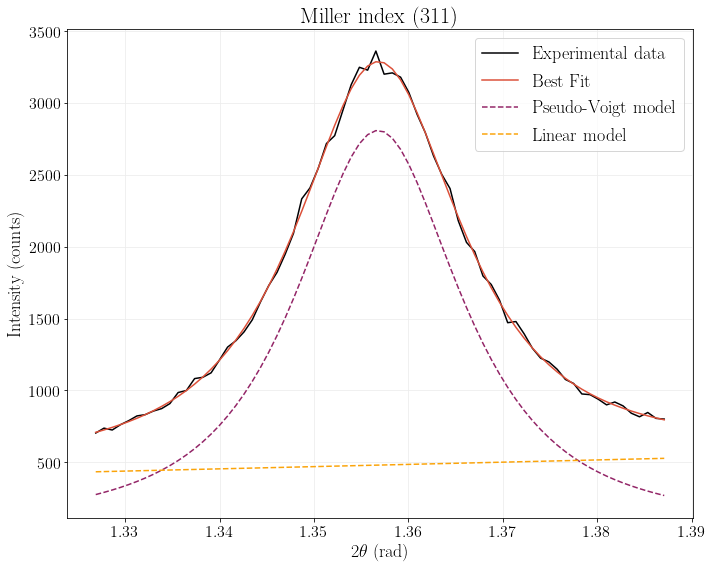

In [9]:
data_peak_4 = data[data['x']>=76]
data_peak_4 = data_peak_4[data_peak_4['x']<=79.5]

x = np.array( data_peak_4['x'] )/180 * np.pi
y = np.array( data_peak_4['y'] )

peak = PseudoVoigtModel(prefix='peak_')
pars = peak.guess(y, x=x)

background = LinearModel(prefix='linear_')
pars.update(background.make_params())

# MODEL
model = peak + background

out = model.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.5))


center_4 = out.params['peak_center'].value
sigma_4  = out.params['peak_sigma'].value
fwhm_4   = out.params['peak_fwhm'].value
height_4 = out.params['peak_height'].value


comps = out.eval_components(x=x)

y_peak = np.array(comps['peak_'])

data_d = {'x': x, 'y': y_peak}
data_int = pd.DataFrame(data=data_d)
data_int = data_int[data_int['x']>=(center_4-3*fwhm_4/2)]
data_int = data_int[data_int['x']<=(center_4+3*fwhm_4/2)]

integral_4 = trapz(data_int['y'], data_int['x'])

beta_breadth_4 = np.sqrt( np.power(integral_4/height_4,2) - np.power(beta_instrumental,2) )
beta_fwhm_4 = np.sqrt( np.power(fwhm_4,2) - np.power(beta_instrumental,2) )

#beta_breadth_4 = integral_4/height_4 - beta_instrumental
#beta_fwhm_4 =  fwhm_4 - beta_instrumental

D_v_fwhm_4 = K_fwhm * lambda_Cu/ (beta_fwhm_4* np.cos(center_4/2))
D_v_breadth_4 = K_breadth * lambda_Cu/ (beta_breadth_4* np.cos(center_4/2))

print('\n')
print('Beta: FWHM = {:18.16f}'.format(beta_fwhm_4))
print('Beta: Integral breadth = {:18.16f}'.format(beta_breadth_4))
print('D FWHM = {:18.16f}'.format(D_v_fwhm_4))
print('D breadth = {:18.16f}'.format(D_v_breadth_4))


fig, axes = plt.subplots(1, 1, figsize=(10, 8))

axes.plot(x, y, 'b',color='#000003',label='Experimental data')
axes.plot(x, out.best_fit, 'r-', color='#DC5039',label='Best Fit')
axes.plot(x, comps['peak_'], 'g--', color='#932567', label='Pseudo-Voigt model')
axes.plot(x, comps['linear_'], 'm--', color='#FBA40A', label='Linear model')
axes.legend(loc='best',fontsize=18)
#axes[1].axvline(x=center_1,color='green')
axes.set_xlabel(r'$ 2 \theta$ (rad)',fontsize=18)
axes.set_ylabel(r'Intensity (counts)',fontsize=18)
axes.tick_params(axis="x", labelsize=16)
axes.tick_params(axis="y", labelsize=16)
axes.grid(color='0.93')
axes.set_title(r'Miller index (311)',fontsize=22)

if not os.path.isdir('./data2/images'):
        os.mkdir('./data2/images')
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('data2/images/4_peak.pdf', format='pdf')

#### Fit 5

[[Model]]
    (Model(pvoigt, prefix='peak_') + Model(linear, prefix='linear_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 100
    # variables        = 6
    chi-square         = 79413.0116
    reduced chi-square = 844.819272
    Akaike info crit   = 679.724732
    Bayesian info crit = 695.355753
[[Variables]]
    peak_amplitude:    18.3468032 +/- 1.30319720 (7.10%) (init = 37.18206)
    peak_center:       1.42943523 +/- 1.3116e-04 (0.01%) (init = 1.428518)
    peak_sigma:        0.00954081 +/- 2.1303e-04 (2.23%) (init = 0.01134464)
    peak_fraction:     0.60828226 +/- 0.12011087 (19.75%) (init = 0.5)
    peak_fwhm:         0.01908161 +/- 4.2606e-04 (2.23%) == '2.0000000*peak_sigma'
    peak_height:       726.155403 +/- 17.8265622 (2.45%) == '(((1-peak_fraction)*peak_amplitude)/max(2.220446049250313e-16, (peak_sigma*sqrt(pi/log(2))))+(peak_fraction*peak_amplitude)/max(2.220446049250313e-16, (pi*peak_sigma)))'
    linear_slo

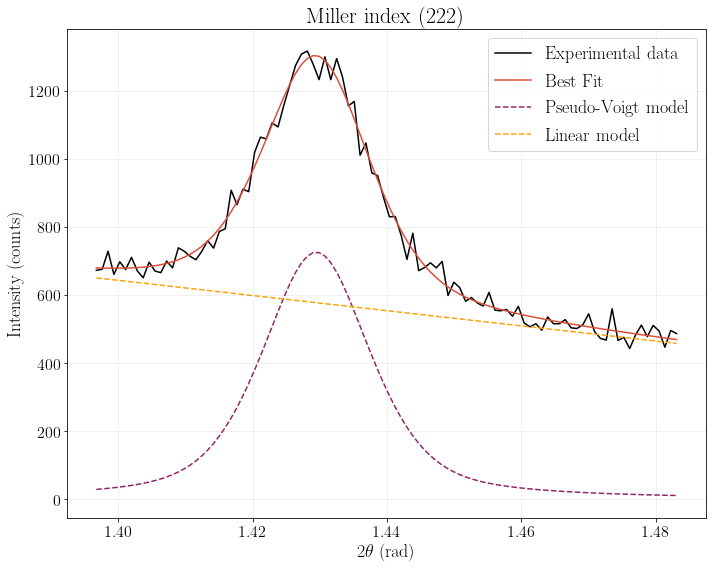

In [10]:
data_peak_5 = data[data['x']>=80]
data_peak_5 = data_peak_5[data_peak_5['x']<=85]

x = np.array( data_peak_5['x'] )/180 * np.pi
y = np.array( data_peak_5['y'] )

peak = PseudoVoigtModel(prefix='peak_')
pars = peak.guess(y, x=x)

background = LinearModel(prefix='linear_')
pars.update(background.make_params())

# MODEL
model = peak + background

out = model.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.5))


center_5 = out.params['peak_center'].value
sigma_5  = out.params['peak_sigma'].value
fwhm_5   = out.params['peak_fwhm'].value
height_5 = out.params['peak_height'].value


comps = out.eval_components(x=x)

y_peak = np.array(comps['peak_'])

data_d = {'x': x, 'y': y_peak}
data_int = pd.DataFrame(data=data_d)
data_int = data_int[data_int['x']>=(center_5-3*fwhm_5/2)]
data_int = data_int[data_int['x']<=(center_5+3*fwhm_5/2)]

integral_5 = trapz(data_int['y'], data_int['x'])

beta_breadth_5 = np.sqrt( np.power(integral_5/height_5,2) - np.power(beta_instrumental,2) )
beta_fwhm_5 = np.sqrt( np.power(fwhm_5,2) - np.power(beta_instrumental,2) )

#beta_breadth_5 = integral_5/height_5 - beta_instrumental
#beta_fwhm_5 =  fwhm_5 - beta_instrumental

D_v_fwhm_5 = K_fwhm * lambda_Cu/ (beta_fwhm_5* np.cos(center_5/2))
D_v_breadth_5 = K_breadth * lambda_Cu/ (beta_breadth_5* np.cos(center_5/2))

print('\n')
print('Beta: FWHM = {:18.16f}'.format(beta_fwhm_5))
print('Beta: Integral breadth = {:18.16f}'.format(beta_breadth_5))
print('D FWHM = {:18.16f}'.format(D_v_fwhm_5))
print('D breadth = {:18.16f}'.format(D_v_breadth_5))


fig, axes = plt.subplots(1, 1, figsize=(10, 8))

axes.plot(x, y, 'b',color='#000003',label='Experimental data')
axes.plot(x, out.best_fit, 'r-', color='#DC5039',label='Best Fit')
axes.plot(x, comps['peak_'], 'g--', color='#932567', label='Pseudo-Voigt model')
axes.plot(x, comps['linear_'], 'm--', color='#FBA40A', label='Linear model')
axes.legend(loc='best',fontsize=18)
#axes[1].axvline(x=center_1,color='green')
axes.set_xlabel(r'$ 2 \theta$ (rad)',fontsize=18)
axes.set_ylabel(r'Intensity (counts)',fontsize=18)
axes.tick_params(axis="x", labelsize=16)
axes.tick_params(axis="y", labelsize=16)
axes.grid(color='0.93')
axes.set_title(r'Miller index (222)',fontsize=22)

if not os.path.isdir('./data2/images'):
        os.mkdir('./data2/images')
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('data2/images/5_peak.pdf', format='pdf')


### Miller indexes and bulk constant

In [11]:
# Import experimental Bulk Dielectric Function for Au (in ordine di intensità dei picchi)
path      = "data2/structure_form.txt"
cols      = pd.read_csv(path, sep="\s+", nrows=1, header=None).iloc[0].values[0:]
structure_data = pd.read_csv(path,sep="\s+",skiprows=1,header=None,names=cols)

structure_data['intensity'] = 16 * structure_data['f(G)']

structure_data

,x,y,z,G,f(G),intensity
0,1,1,1,1.732,72.366699,1157.867182
1,2,0,0,2.000,70.642644,1130.282303
2,2,2,0,2.828,65.208797,1043.340751
3,3,1,1,3.317,62.123863,993.981811
4,4,0,0,4.000,58.078394,929.254297


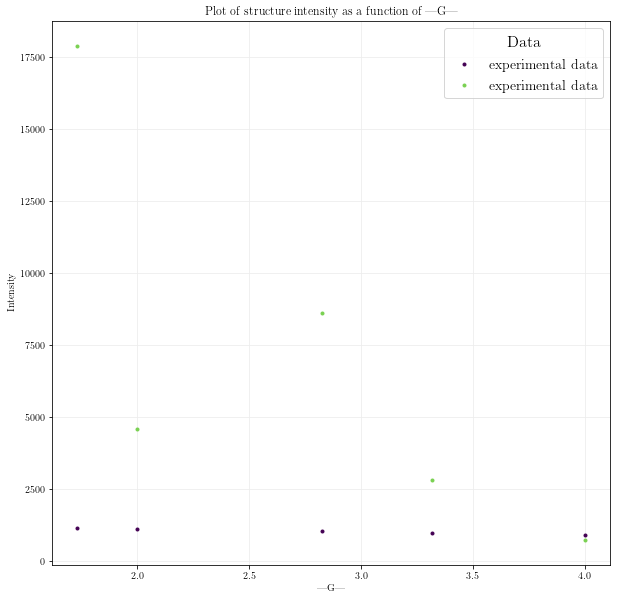

In [12]:
# Plot of structure intensity as a function of |G| (in ordine di intensità dei picchi)
heights = [height_1,height_2,height_3,height_4,height_5]

fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))

ax1.plot(structure_data['G'],structure_data['intensity'],'.',color=palette.viridis(6)[0],label='experimental data')
ax1.plot(structure_data['G'],heights,'.',color=palette.viridis(6)[4],label='experimental data')

ax1.set_title('Plot of structure intensity as a function of |G|')
ax1.set_xlabel('|G|')
ax1.set_ylabel('Intensity')
ax1.grid(color='0.93')
ax1.legend(title='Data',fontsize=14,  title_fontsize=16,loc='upper right')

#if not os.path.isdir('./hist_fMT'):
#        os.mkdir('./hist_fMT')
#
#plt.savefig('hist_fMT/frac_CE.pdf', format='pdf')
#plt.close()

In [13]:
#  (NON in ordine di intensità dei picchi) # RICONTROLLAREEEEEEEE
def d_func(theta):
    return lambda_Cu/(2*np.sin(theta/2)) # THETA/2!!!

d_1 = d_func(center_1)
a_1 = d_1 * np.power(3,1/2)

d_2 = d_func(center_2)
a_2 = d_2 * 2 #np.power(8,1/2)

d_3 = d_func(center_3)
a_3 = d_3 * np.power(8,1/2) #2

d_4 = d_func(center_4)
a_4 = d_4 * np.power(11,1/2)

d_5 = d_func(center_5)
a_5 = d_5 * np.power(12,1/2)


print('a_1 =', a_1,'\n')
print('a_2 =', a_2,'\n')
print('a_3 =', a_3,'\n')
print('a_4 =', a_4,'\n')
print('a_5 =', a_5,'\n')

a_values = [a_1,a_2,a_3,a_4,a_5]

a_1 = 0.40689203944859914 

a_2 = 0.4074192506790682 

a_3 = 0.4066652729057102 

a_4 = 0.40710928595276835 

a_5 = 0.4071377053877682 



In [31]:
center = [center_1,center_2,center_3,center_4,center_5]
err_center = [2.5038e-05, 4.8690e-05, 1.9541e-05, 4.2203e-05, 1.3116e-04]
k = [3,4,8,11,12]

#err_t = [ i/2 for i in err_center]

def err_a_func(center,err,k):
    err_theta = err/2
    lambda_Cu = 0.15406
    return ( lambda_Cu*np.cos(center/2)/ (2*np.sin(center/2)**2) ) * k**(1/2) * err_theta


err_a_1 = err_a_func(center[0],err_center[0],k[0])
err_a_2 = err_a_func(center[1],err_center[1],k[1])
err_a_3 = err_a_func(center[2],err_center[2],k[2])
err_a_4 = err_a_func(center[3],err_center[3],k[3])
err_a_5 = err_a_func(center[4],err_center[4],k[4])

err_a = [err_a_1,err_a_2,err_a_3,err_a_4,err_a_5]

print(center)
print(err_a)

#print(err_center)
#print(center)

perc = (np.array(err_center)*100/ np.array(center))#*100
perc_a = (np.array(err_a)*100/ np.array(a_values))#*100
perc_a

0.00001

[0.6681594975301818, 0.7755645336755215, 1.130807886158802, 1.3567933579611875, 1.4294352310576919]
[1.4675981111113729e-05, 2.4282682970322216e-05, 6.2621004050904795e-06, 1.0658161068206582e-05, 3.076880114563306e-05]


1e-05

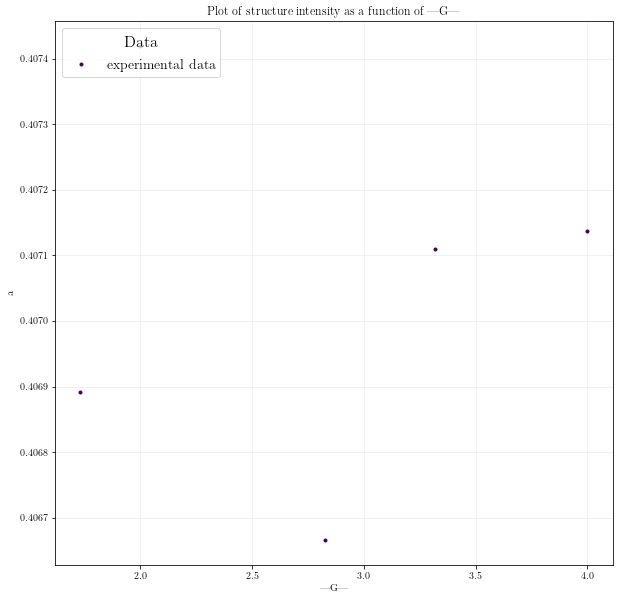

In [15]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))

ax1.plot(structure_data['G'],a_values,'.',color='#440154',label='experimental data')

ax1.set_title('Plot of structure intensity as a function of |G|')
ax1.set_xlabel('|G|')
ax1.set_ylabel('a')
ax1.grid(color='0.93')
ax1.legend(title='Data',fontsize=14,  title_fontsize=16,loc='upper left')

### D_FWHM and D_breadth as a function of the peak center

In [16]:
centers = [center_1,center_2,center_3,center_4,center_5]
D_v_fwhms = [D_v_fwhm_1,D_v_fwhm_2,D_v_fwhm_3,D_v_fwhm_4,D_v_fwhm_5]
D_v_breadths = [D_v_breadth_1,D_v_breadth_2,D_v_breadth_3,D_v_breadth_4,D_v_breadth_5]

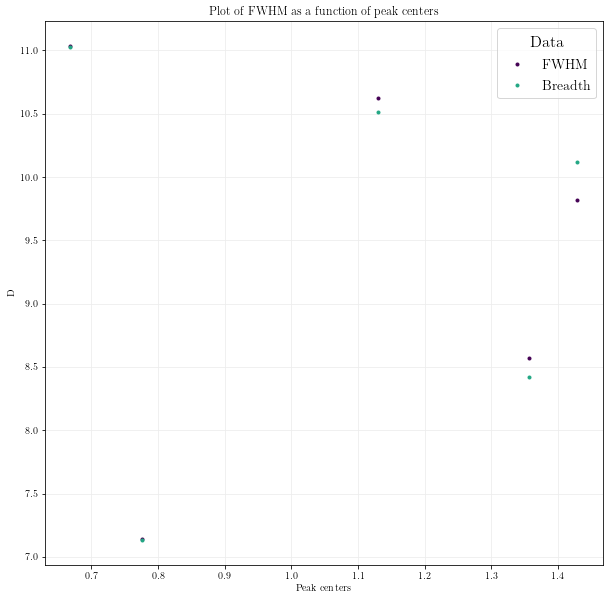

In [17]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))

ax1.plot(centers,D_v_fwhms,'.',color=palette.viridis(6)[0],label='FWHM')
ax1.plot(centers,D_v_breadths,'.',color=palette.viridis(6)[3],label='Breadth')

ax1.set_title('Plot of FWHM as a function of peak centers')
ax1.set_xlabel('Peak centers')
ax1.set_ylabel('D')
ax1.grid(color='0.93')
ax1.legend(title='Data',fontsize=14,  title_fontsize=16,loc='upper right')

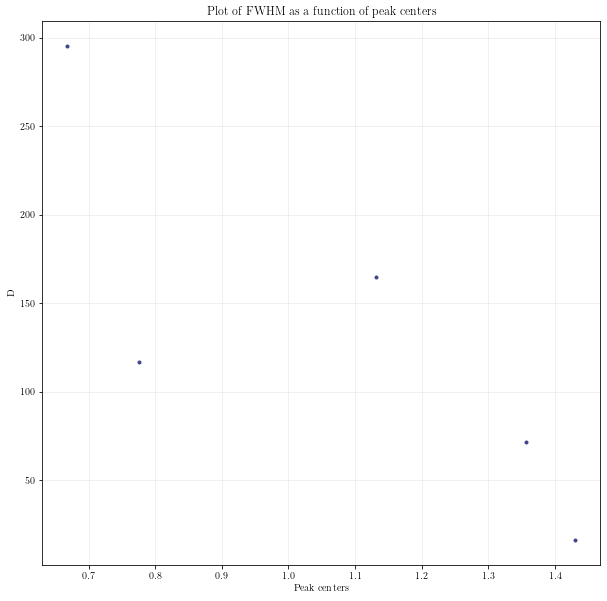

In [18]:
integrals =[integral_1,integral_2,integral_3,integral_4,integral_5]

fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))

ax1.plot(centers,integrals,'.',color=palette.viridis(6)[1])
#ax1.plot(centers,heights,'.',color=palette.viridis(6)[4])

ax1.set_title('Plot of FWHM as a function of peak centers')
ax1.set_xlabel('Peak centers')
ax1.set_ylabel('D')
ax1.grid(color='0.93')
#ax1.legend(title='Data',fontsize=14,  title_fontsize=16,loc='upper left')


### Williamson-Hall analysis

In [19]:
# FIT 1
data_peak_1 = data[data['x']>=36]
data_peak_1 = data_peak_1[data_peak_1['x']<=40.5]

x = np.array( data_peak_1['x'] )/180 * np.pi
y = np.array( data_peak_1['y'] )

peak = PseudoVoigtModel(prefix='peak_')
pars = peak.guess(y, x=x)

background = LinearModel(prefix='linear_')
pars.update(background.make_params())

# MODEL
model = peak + background

out = model.fit(y, pars, x=x)

center_1 = out.params['peak_center'].value
sigma_1  = out.params['peak_sigma'].value
fwhm_1   = out.params['peak_fwhm'].value
height_1 = out.params['peak_height'].value

comps = out.eval_components(x=x)

y_peak = np.array(comps['peak_'])

data_d = {'x': x, 'y': y_peak}
data_int = pd.DataFrame(data=data_d)
data_int = data_int[data_int['x']>=(center_1-3*fwhm_1/2)]
data_int = data_int[data_int['x']<=(center_1+3*fwhm_1/2)]

integral_1 = trapz(data_int['y'], data_int['x'])



beta_breadth_1 = integral_1/height_1 - beta_instrumental
beta_fwhm_1 =  fwhm_1 - beta_instrumental

x_w_1 = 4 * np.sin(center_1/2)
y_w_breadth_1 = beta_breadth_1 * np.cos(center_1/2)

#print('\n')
#print('Beta: FWHM = {:18.16f}'.format(beta_fwhm_1))
#print('Beta: Integral breadth = {:18.16f}'.format(beta_breadth_1))
#

In [20]:
# FIT 2
data_peak_2 = data[data['x']>=42]
data_peak_2 = data_peak_2[data_peak_2['x']<=47]

x = np.array( data_peak_2['x'] )/180 * np.pi
y = np.array( data_peak_2['y'] )

peak = PseudoVoigtModel(prefix='peak_')
pars = peak.guess(y, x=x)

background = LinearModel(prefix='linear_')
pars.update(background.make_params())

# MODEL
model = peak + background

out = model.fit(y, pars, x=x)

center_2 = out.params['peak_center'].value
sigma_2  = out.params['peak_sigma'].value
fwhm_2   = out.params['peak_fwhm'].value
height_2 = out.params['peak_height'].value

comps = out.eval_components(x=x)

y_peak = np.array(comps['peak_'])

data_d = {'x': x, 'y': y_peak}
data_int = pd.DataFrame(data=data_d)
data_int = data_int[data_int['x']>=(center_2-3*fwhm_2/2)]
data_int = data_int[data_int['x']<=(center_2+3*fwhm_2/2)]

integral_2 = trapz(data_int['y'], data_int['x'])



beta_breadth_2 = integral_2/height_2 - beta_instrumental
beta_fwhm_2 =  fwhm_2 - beta_instrumental

x_w_2 = 4 * np.sin(center_2/2)
y_w_breadth_2 = beta_breadth_2 * np.cos(center_2/2)


In [21]:
# FIT 3
data_peak_3 = data[data['x']>=61]
data_peak_3 = data_peak_3[data_peak_3['x']<=69]

x = np.array( data_peak_3['x'] )/180 * np.pi
y = np.array( data_peak_3['y'] )

peak = PseudoVoigtModel(prefix='peak_')
pars = peak.guess(y, x=x)

background = LinearModel(prefix='linear_')
pars.update(background.make_params())

# MODEL
model = peak + background

out = model.fit(y, pars, x=x)

center_3 = out.params['peak_center'].value
sigma_3  = out.params['peak_sigma'].value
fwhm_3   = out.params['peak_fwhm'].value
height_3 = out.params['peak_height'].value


comps = out.eval_components(x=x)

y_peak = np.array(comps['peak_'])

data_d = {'x': x, 'y': y_peak}
data_int = pd.DataFrame(data=data_d)
data_int = data_int[data_int['x']>=(center_3-3*fwhm_3/2)]
data_int = data_int[data_int['x']<=(center_3+3*fwhm_3/2)]

integral_3 = trapz(data_int['y'], data_int['x'])

beta_breadth_3 = integral_3/height_3 - beta_instrumental
beta_fwhm_3 =  fwhm_3 - beta_instrumental

x_w_3 = 4 * np.sin(center_3/2)
y_w_breadth_3 = beta_breadth_3 * np.cos(center_3/2)

In [22]:
# FIT 4
data_peak_4 = data[data['x']>=76]
data_peak_4 = data_peak_4[data_peak_4['x']<=79.5]

x = np.array( data_peak_4['x'] )/180 * np.pi
y = np.array( data_peak_4['y'] )

peak = PseudoVoigtModel(prefix='peak_')
pars = peak.guess(y, x=x)

background = LinearModel(prefix='linear_')
pars.update(background.make_params())

# MODEL
model = peak + background

out = model.fit(y, pars, x=x)

center_4 = out.params['peak_center'].value
sigma_4  = out.params['peak_sigma'].value
fwhm_4   = out.params['peak_fwhm'].value
height_4 = out.params['peak_height'].value


comps = out.eval_components(x=x)

y_peak = np.array(comps['peak_'])

data_d = {'x': x, 'y': y_peak}
data_int = pd.DataFrame(data=data_d)
data_int = data_int[data_int['x']>=(center_4-3*fwhm_4/2)]
data_int = data_int[data_int['x']<=(center_4+3*fwhm_4/2)]

integral_4 = trapz(data_int['y'], data_int['x'])

beta_breadth_4 = integral_4/height_4 - beta_instrumental
beta_fwhm_4 =  fwhm_4 - beta_instrumental

x_w_4 = 4 * np.sin(center_4/2)
y_w_breadth_4 = beta_breadth_3 * np.cos(center_4/2)


In [23]:
# FIT 5
data_peak_5 = data[data['x']>=80]
data_peak_5 = data_peak_5[data_peak_5['x']<=85]

x = np.array( data_peak_5['x'] )/180 * np.pi
y = np.array( data_peak_5['y'] )

peak = PseudoVoigtModel(prefix='peak_')
pars = peak.guess(y, x=x)

background = LinearModel(prefix='linear_')
pars.update(background.make_params())

# MODEL
model = peak + background

out = model.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.5))


center_5 = out.params['peak_center'].value
sigma_5  = out.params['peak_sigma'].value
fwhm_5   = out.params['peak_fwhm'].value
height_5 = out.params['peak_height'].value


comps = out.eval_components(x=x)

y_peak = np.array(comps['peak_'])

data_d = {'x': x, 'y': y_peak}
data_int = pd.DataFrame(data=data_d)
data_int = data_int[data_int['x']>=(center_5-3*fwhm_5/2)]
data_int = data_int[data_int['x']<=(center_5+3*fwhm_5/2)]

integral_5 = trapz(data_int['y'], data_int['x'])

beta_breadth_5 = integral_5/height_5 - beta_instrumental
beta_fwhm_5 =  fwhm_5 - beta_instrumental

x_w_5 = 4 * np.sin(center_5/2)
y_w_breadth_5 = beta_breadth_5 * np.cos(center_5/2)


[[Model]]
    (Model(pvoigt, prefix='peak_') + Model(linear, prefix='linear_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 100
    # variables        = 6
    chi-square         = 79413.0116
    reduced chi-square = 844.819272
    Akaike info crit   = 679.724732
    Bayesian info crit = 695.355753
[[Variables]]
    peak_amplitude:    18.3468032 +/- 1.30319720 (7.10%) (init = 37.18206)
    peak_center:       1.42943523 +/- 1.3116e-04 (0.01%) (init = 1.428518)
    peak_sigma:        0.00954081 +/- 2.1303e-04 (2.23%) (init = 0.01134464)
    peak_fraction:     0.60828226 +/- 0.12011087 (19.75%) (init = 0.5)
    peak_fwhm:         0.01908161 +/- 4.2606e-04 (2.23%) == '2.0000000*peak_sigma'
    peak_height:       726.155403 +/- 17.8265622 (2.45%) == '(((1-peak_fraction)*peak_amplitude)/max(2.220446049250313e-16, (peak_sigma*sqrt(pi/log(2))))+(peak_fraction*peak_amplitude)/max(2.220446049250313e-16, (pi*peak_sigma)))'
    linear_slo

[[Model]]
    Model(linear, prefix='linear_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 5
    # variables        = 2
    chi-square         = 3.9185e-05
    reduced chi-square = 1.3062e-05
    Akaike info crit   = -54.7832586
    Bayesian info crit = -55.5643827
[[Variables]]
    linear_slope:     -0.00196439 +/- 0.00308021 (156.80%) (init = 1)
    linear_intercept:  0.01734180 +/- 0.00642791 (37.07%) (init = 0)
[[Correlations]] (unreported correlations are < 0.500)
    C(linear_slope, linear_intercept) = -0.968


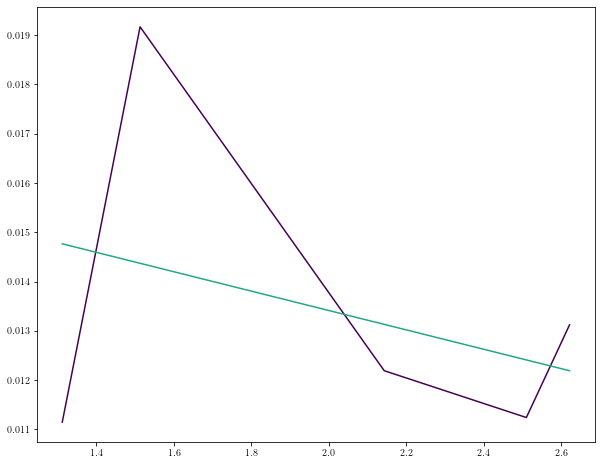

In [24]:
y_w_breadth = [y_w_breadth_1,y_w_breadth_2,y_w_breadth_3,y_w_breadth_4,y_w_breadth_5]
x_w = [x_w_1,x_w_2,x_w_3,x_w_4,x_w_5]

# MODEL
model = LinearModel(prefix='linear_')
#pars.update(model.make_params())

out = model.fit(y_w_breadth, x=x_w)

print(out.fit_report(min_correl=0.5))
#comps = out.eval_components(x=x_w)

fig, axes = plt.subplots(1, 1, figsize=(10, 8))

axes.plot(x_w, y_w_breadth, 'b',color='#440154',label='Experimental data')
axes.plot(x_w, out.best_fit, 'r-', color='#22A784',label='Best Fit')
#axes.plot(x_w, comps['linear_'], 'm--', color='#79D151', label='Linear model')



In [25]:
y_w_breadth

[0.011148467735460623,
 0.019165534182505512,
 0.01219255657816983,
 0.011242528568665314,
 0.013121622142601043]